# 0. Импорты и определения

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = pd.to_datetime(profiles['first_ts'].dt.date)
    profiles['month'] = profiles['first_ts'].values.astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [3]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [4]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [5]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [6]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [7]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [8]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [9]:
# функцция для получения сводной таблицы

def get_payers_stat(profiles, dimension):
    
    payers_stat = (
        profiles.pivot_table(index=dimension,
                             columns='payer',
                             values='user_id',
                             aggfunc='nunique',
                             margins=True,
                             margins_name='total')
        .rename(columns={False: 'non_payers', True: 'payers'})
    )
    
    payers_stat['payers_percent'] = round(
        100 * (payers_stat['payers'] / (payers_stat['payers'] + payers_stat['non_payers'])), 2
    )
    
    payers_stat = payers_stat.sort_values(by='total').drop('total', axis=0)
    
    return payers_stat

In [10]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(14, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [11]:
sns.set_style('darkgrid')

# 1. Подготовка данных

In [12]:
# Загрузка данных
visits = pd.read_csv('')
orders = pd.read_csv('')
costs = pd.read_csv('')

## 1.1. Приведем названия столбцов в стандартный вид

In [13]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
costs.columns = costs.columns.str.lower().str.replace(' ', '_')

## 1.2. Обработаем датафрейм *visits*

Проверим типы данных, наличие пропусков и дубликатов.

In [14]:
visits.head()

user_id         region   device  channel        session_start   
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01  \
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           session_end  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

In [15]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [16]:
visits[visits.duplicated()]

Empty DataFrame
Columns: [user_id, region, device, channel, session_start, session_end]
Index: []

Пропусков и дубликатов в датафрейме нет, но есть неправильные типы данных. Приведем столбцы с датами к типу *datetime*.

In [17]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

## 1.3. Обработаем датафрейм *orders*

In [18]:
orders.head()

user_id             event_dt  revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

In [19]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [20]:
orders[orders.duplicated()]

Empty DataFrame
Columns: [user_id, event_dt, revenue]
Index: []

In [21]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

## 1.4. Обработаем датафрейм *costs*

In [22]:
costs.head()

dt   channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

In [23]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [24]:
costs[costs.duplicated()]

Empty DataFrame
Columns: [dt, channel, costs]
Index: []

In [25]:
costs['dt'] = pd.to_datetime(costs['dt'])

In [26]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


Серьезных проблем с данными мы не выявили: нет ни полных дубликатов, ни пропусков. Были проблемы с типами данных в столбцах с датами, их мы исправили. Можем приступать к анализу.

# 2. Исследовательский анализ данных
## 2.1. Профили пользователей

На основе датафреймов visits на orders составляем профили пользователей. А также определяем самую раннюю и самую позднюю дату привлечения пользователей.

In [27]:
profiles = get_profiles(visits, orders, costs)

profiles.head()

user_id            first_ts     channel  device         region         dt   
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States 2019-05-07  \
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States 2019-07-09   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France 2019-10-01   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany 2019-08-22   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States 2019-10-02   

       month  payer  acquisition_cost  
0 2019-05-01   True          1.088172  
1 2019-07-01  False          1.107237  
2 2019-10-01  False          0.000000  
3 2019-08-01  False          0.988235  
4 2019-10-01  False          0.230769

In [28]:
min_acquisition_date = profiles['dt'].min()
max_acquisition_date = profiles['dt'].max()

print(f'Самая ранняя дата привлечения: {min_acquisition_date}')
print(f'Самая поздняя дата привлечения: {max_acquisition_date}')

Самая ранняя дата привлечения: 2019-05-01 00:00:00
Самая поздняя дата привлечения: 2019-10-27 00:00:00


## 2.1. Среднее число платящих пользователей

Вычислим среднее число платящих пользователей во всем датасете.

In [29]:
round(100 * profiles['payer'].mean(), 2)

5.92

## 2.2. Анализ стран привлеченных пользователей

Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.

In [30]:
regions_stat = get_payers_stat(profiles, dimension='region')

(
    regions_stat.sort_values(by='total', ascending=False)
    .style
    .format({'payers_percent': '{:.2f}%'})
    .background_gradient(subset=['total', 'payers_percent'], 
                         cmap='Greens')
    .set_caption('Платящие пользователи по странам')
    .set_table_styles([{'selector': 'caption',
                        'props': [('font-size', '16px'), ('font-weight', 'bold')]}])
)

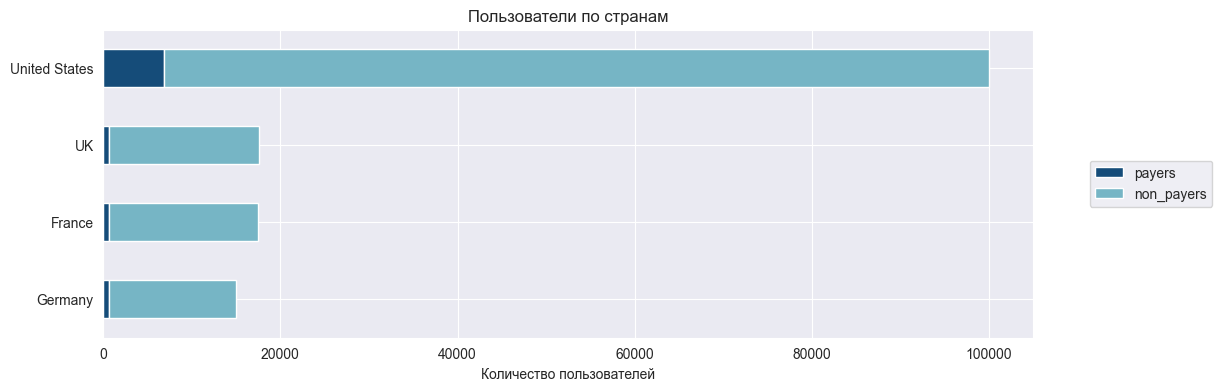

In [31]:
fig, ax = plt.subplots(figsize=(12, 4))

regions_stat.loc[regions_stat.index != 'total', ['payers', 'non_payers']].plot(kind='barh', 
                                            stacked=True, 
                                            color=['#154c79', '#76b5c5'], 
                                            ax=ax)

ax.set(title='Пользователи по странам', xlabel='Количество пользователей', ylabel='')
ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5));

Большинство привлеченных за период с 1 мая по 27 октября - это пользователи из Соединённых штатов, их 100 тысяч человек. На втором месте - Соединенное Королевство и Франция. Меньше всего пользователей из Германии - меньше 15 тысяч.

Доля платящих пользователей тоже больше всего в США - 6.9% от общего числа. У остальных стран эта доля примерно одинакова и составляет около 4%.

## 2.3. Анализ устройств привлеченных пользователей

Определим, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.

In [32]:
device_stat = get_payers_stat(profiles, dimension='device')

(
    device_stat.sort_values(by='total', ascending=False)
    .style
    .format({'payers_percent': '{:.2f}%'})
    .background_gradient(subset=['total', 'payers_percent'], 
                         cmap='Greens')
    .set_caption('Платящие пользователи по устройствам')
    .set_table_styles([{'selector': 'caption',
                        'props': [('font-size', '16px'), ('font-weight', 'bold')]}])
)

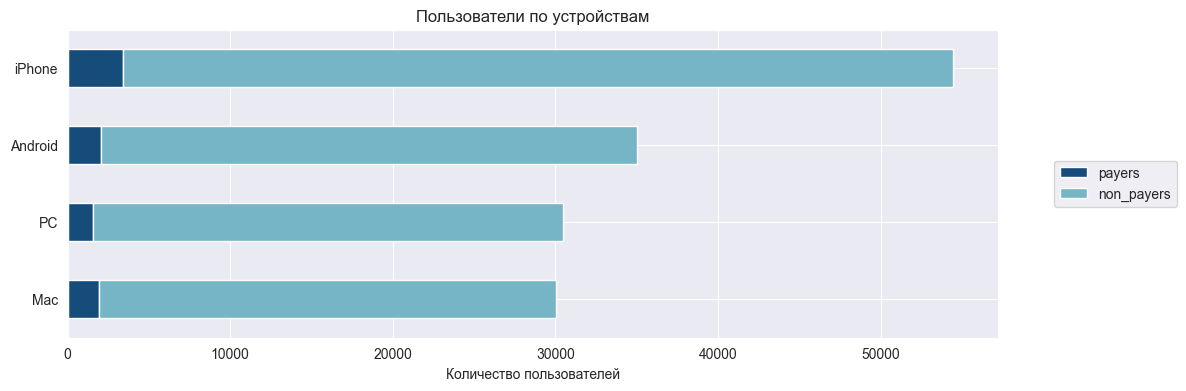

In [33]:
fig, ax = plt.subplots(figsize=(12, 4))

device_stat.loc[device_stat.index != 'total', ['payers', 'non_payers']].plot(kind='barh', 
                                            stacked=True, 
                                            color=['#154c79', '#76b5c5'], 
                                            ax=ax)

ax.set(title='Пользователи по устройствам', xlabel='Количество пользователей', ylabel='')
ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5));

Самые распространенные устройства у наших пользователей - это iPhone, таких 54 тысячи, это больше трети всех пользователей. Остальных типов устройств примерно поровну: 35 тысяч пользователей платформы Android, по 30 тысяч Mac и PC.

Доля платящих пользователей на всех платформах кроме PC составляет около 6%. Платящих пользователей PC чуть меньше, чем на остальных платформах - всего 5%

## 2.4. Анализ каналов привлечения

Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей.

In [34]:
channel_stat = get_payers_stat(profiles, dimension='channel')


(
    channel_stat.sort_values(by='total', ascending=False)
    .style
    .format({'payers_percent': '{:.2f}%'})
    .background_gradient(subset=['total', 'payers_percent'], 
                         cmap='Greens')
    .set_caption('Платящие пользователи по каналам')
    .set_table_styles([{'selector': 'caption',
                        'props': [('font-size', '16px'), ('font-weight', 'bold')]}])
)

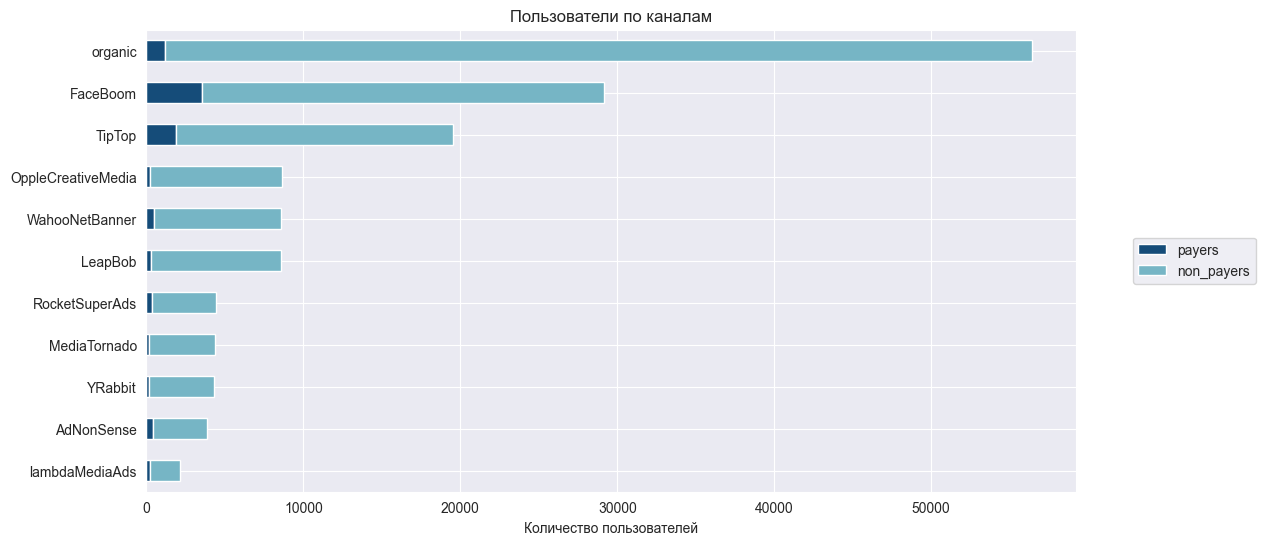

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))

channel_stat.loc[channel_stat.index != 'total', ['payers', 'non_payers']].plot(kind='barh', 
                                            stacked=True, 
                                            color=['#154c79', '#76b5c5'], 
                                            ax=ax)

ax.set(title='Пользователи по каналам', xlabel='Количество пользователей', ylabel='')
ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5));

Из таблицы видно, что распределение пользователей по каналам привлечения более разнообразное, чем по платформам и странам. И самих каналов больше - 11 штук, и все они привлекают разное количество пользователей. Самый массовый канал - это organic - ораническая поисковая выдача (56 тысяч пользователей, больше трети от общего числа). Среди платных каналов привлечения самый массовый - это FaceBoom, с него пришло 29 тысяч пользователей, на втором месте TipTop и 19 тысяч, на третьем OppleCreativeMedia и 8 тысяч. Самый скромный результат у lambdaMediaAds - всего 2 тысячи пользователей.

Если сравнивать доли платящих пользователей, то здесь тоже в лидерах FaceBoom - 12% пользователей сконвертировались в покупку. А вот второе и третье место - это каналы AdNonSense (11%), lambdaMediaAds (10%) и TipTop (10%). И если TipTop входит в тройку самых массовых каналов, то lambdaMediaAds и AdNonSense в этом плане аутсайдеры. Получается, что они хорошо конвертируются в покупку, но почему-то приносят в принципе мало пользователей. Возможно, эти каналы могли бы стать точкой роста, если их масштабировать.

Обобщая анализ пользователей, можем сказать следующее:
- доля платящих пользователей в целом невелика - в среднем 5.92%
- больше всего пользователей приходит из США и они конвертируются лучше других
- большая часть пользователей заходит с мобильных устройств, чаще с iPhone
- лучше всех конвертируются пользователи Apple
- самый массовые наш каналы это FaceBoom и TipTop, FaceBoom еще и конвертируется лучше всех

# 3. Общий анализ окупаемости рекламы

Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

## 3.1. Определим общую сумму расходов на маркетинг

In [36]:
print(f'Общая сумма расходов на маркетинг равна {round(costs.costs.sum())} у.е.')

Общая сумма расходов на маркетинг равна 105497 у.е.


## 3.2. Посмотрим на распределение расходов по рекламным источникам

Построим сводную таблицу, а также визуализируем на графике.

In [37]:
costs_by_channel = (
    costs.groupby(by='channel')
    .agg({'costs': 'sum'})
    .sort_values(by='costs', ascending=False)
    .reset_index()
)

costs_by_channel['channel_share'] = round(100 * costs_by_channel['costs'] / costs_by_channel['costs'].sum(),
                                         2)

(
    costs_by_channel.style
    .format({'costs': '{:.2f}', 'channel_share': '{:.2f}%'})
    .background_gradient(subset=['costs', 'channel_share'], 
                         cmap='Greens')
    .set_caption('Затраты на рекламу в разных источниках')
    .set_table_styles([{'selector': 'caption',
                        'props': [('font-size', '16px'), ('font-weight', 'bold')]}])
)

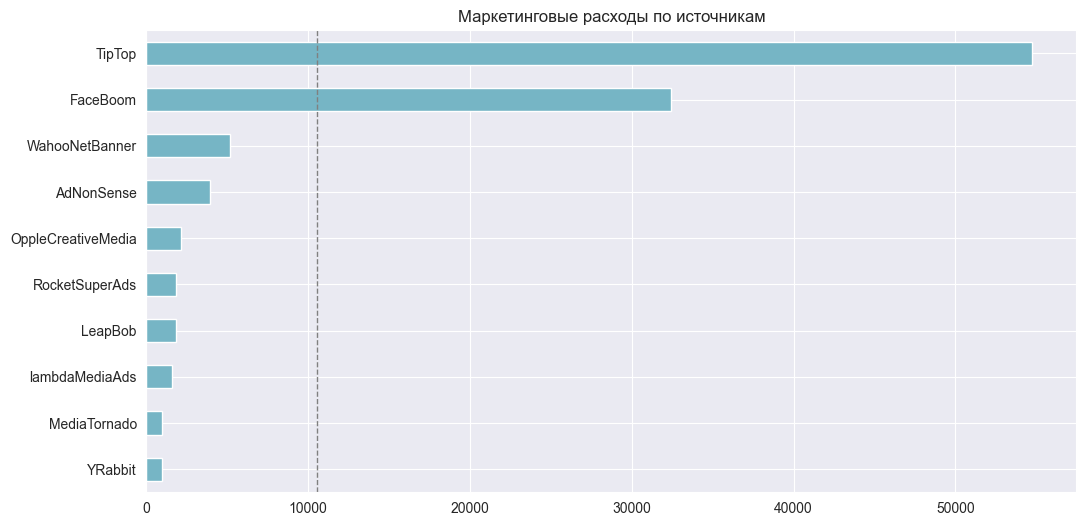

In [38]:
fig, ax = plt.subplots(figsize=(12, 6))

costs_by_channel.sort_values(by='costs').plot(kind='barh', 
                                              x='channel', 
                                              y='costs', 
                                              grid=True,
                                              color='#76b5c5',
                                              ax=ax)
ax.axvline(x=costs_by_channel['costs'].mean(), color='grey', label='Average', linestyle='--', linewidth=1)
ax.set(title='Маркетинговые расходы по источникам', ylabel='')
ax.legend().set_visible(False);

Больше половины всех расходов (54%) - это канал TipTop. Из предыдущего анализа мы помним, что он на втором месте по количеству привлеченных пользователей, и на третьем месте по доле платящих пользователей (10%). На втором месте по расходам канал FaceBoom (31% рекламного бюджета). FaceBoom - лидер по количеству привлеченных пользователей и по доле платящих (12%). 

Выходит, что эти два канала близки по доле платящих пользователей, но сильно различаются по стоимости привлечения.

Затраты на остальные источники распределены довольно равномерно: от 5% на WahooNetBanner до 1% на lambdaMediaAds, MediaTornado и YRabbit. 

Интересно, что на lambdaMediaAds тратится очень небольшая часть бюджета, а у канала при этом хороший процент платящих пользователей.

## 3.3. Посмотрим на динамику расходов по рекламным источникам

Визуализируем изменения рекламных расходов во времени по каждому источнику.

In [39]:
costs['week'] = costs['dt'].dt.isocalendar().week.astype(int)
costs['month'] = costs['dt'].dt.month

costs_stat_weekly = costs.groupby(by=['channel', 'week']).agg({'costs': 'sum'}).reset_index()
costs_stat_monthly = costs.groupby(by=['channel', 'month']).agg({'costs': 'sum'}).reset_index()

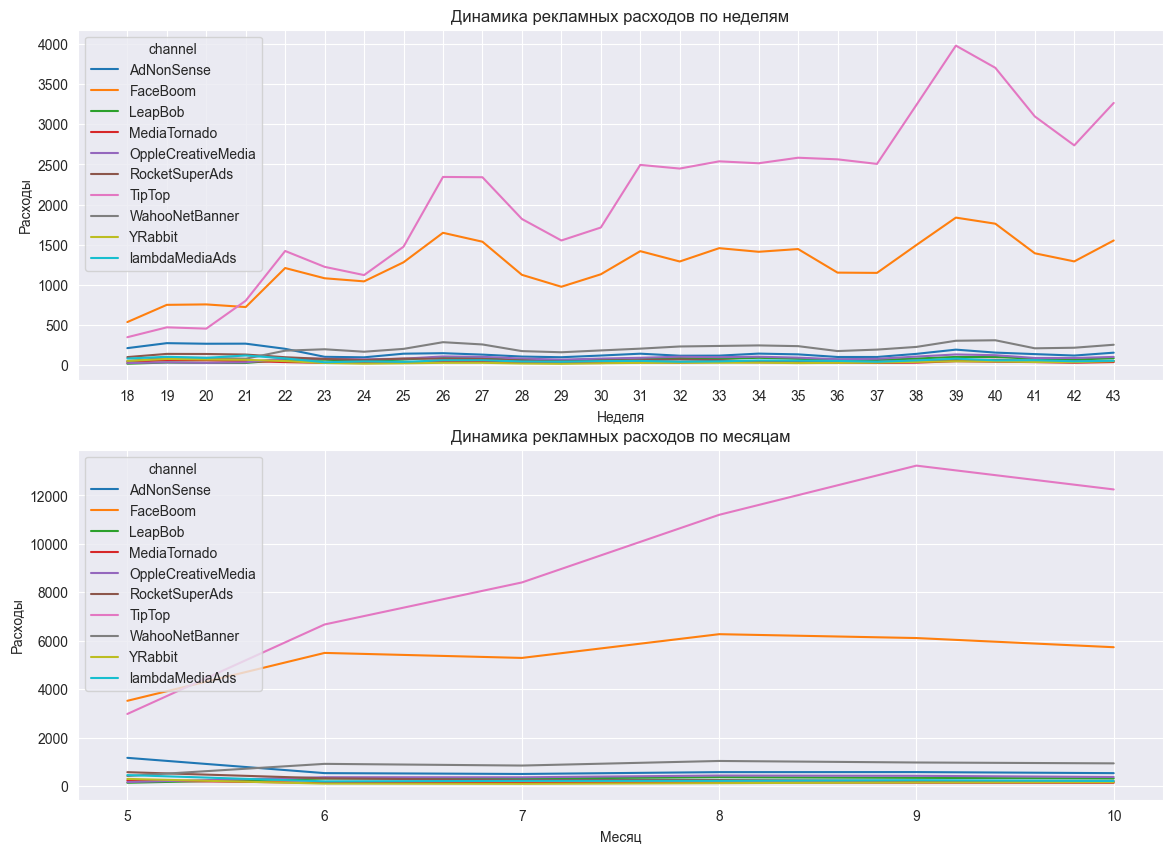

In [40]:
fig, (ax0, ax1) = plt.subplots(figsize=(14, 10), nrows=2, ncols=1)

sns.lineplot(data=costs_stat_weekly, y='costs', x='week', hue='channel', ax=ax0)
ax0.set_xticks(costs_stat_weekly['week'].unique().astype(int))
ax0.set(title='Динамика рекламных расходов по неделям', xlabel='Неделя', ylabel='Расходы')

sns.lineplot(data=costs_stat_monthly, y='costs', x='month', hue='channel', ax=ax1)
ax1.set_xticks(costs_stat_monthly['month'].unique().astype(int))
ax1.set(title='Динамика рекламных расходов по месяцам', xlabel='Месяц', ylabel='Расходы');

Два лидера по затратам - это TipTop и FaceBoom. Интересно, что в начале периода затраты на FaceBoom были больше, чем на TipTop, но ситуация изменилась в мае, на 21 неделе. И до самого конца периода отрыв TipTop все увеличивался. Расходы же на FaceBoom росли более плавно.

Пик затрат на TipTop пришелся на сентябрь - бюджет на канал превысил 13000, для FaceBoom пик - это август и бюджет больше 6000.

На остальные же каналы недельные траты никогда не превышали 500, а месячные не превышали 1500.

## 3.4. Рассчитаем среднюю стоимость привлечения одного пользователя

In [41]:
acquisition_stat = (
    profiles.groupby(by='channel')
    .agg({'acquisition_cost': 'mean'})
    .sort_values(by='acquisition_cost', ascending=False)
    .reset_index()
)

acquisition_stat = acquisition_stat.loc[acquisition_stat['channel'] != 'organic']
acquisition_stat['acquisition_cost'] = round(acquisition_stat['acquisition_cost'], 2)



(
    acquisition_stat.style
    .format({'acquisition_cost': '{:.2f}'})
    .background_gradient(subset=['acquisition_cost'], 
                         cmap='Greens')
    .set_caption('Средняя стоимость привлечения пользователя по источникам')
    .set_table_styles([{'selector': 'caption',
                        'props': [('font-size', '16px'), ('font-weight', 'bold')]}])
)

In [42]:
acquisition_stat_mean = round(acquisition_stat['acquisition_cost'].mean(), 2)

print(f'Средняя стоимость привлечения равна {acquisition_stat_mean}')

Средняя стоимость привлечения равна 0.76


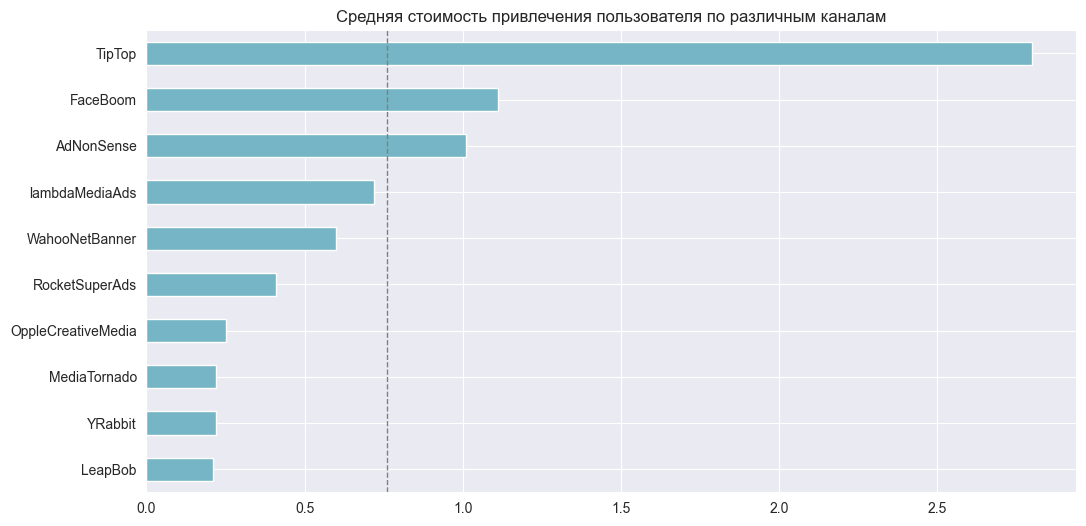

In [43]:
fig, ax = plt.subplots(figsize=(12, 6))

(
    acquisition_stat.sort_values(by='acquisition_cost')
    .plot(kind='barh', 
          x='channel', 
          y='acquisition_cost', 
          color='#76b5c5', 
          ax=ax)
)
ax.axvline(x=acquisition_stat_mean, color='grey', label='Average', linestyle='--', linewidth=1)
ax.set(title='Средняя стоимость привлечения пользователя по различным каналам', ylabel='')
ax.legend().set_visible(False);

Средняя стоимость привлчечения пользователя составляет 0.75. Три канала оказазлись дороже среднего показателя: это TipTop (2.8), FaceBoom (1.11), AdNonSense (1.01).

Как мы и предположили ранее, стоимость привлечения через TipTop гораздо выше, чем через другие каналы, TipTop обгоняет ближайшего конкурента по стоимости (FaceBoom) больше, чем в два раза.

Самыми дешевыми каналами оказались YRabbit, MediaTornado, LeapBob: стоимость привлечения не превышает 0.22. Но эти каналы ничем не выделялись ни в плане количества привлеченных пользователей, ни в плане платящих пользователей. Так что малые затраты на них вполне закономерны.

# 4. Анализ окупаемости рекламы в разрезах по регионам, девайсам, каналам

Задаем дату анализа - 1 ноября 2019 года, горизонт анализа равен 14 дням.

In [44]:
observation_date = pd.to_datetime('2019-11-01')
horizon_days = 14

## 4.1. Общая окупаемость рекламы

Начнем с анализа общей окупаемости рекламы. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI. 
Для анализа отберем только данные рекламных пользователей, то есть исключим органический трафик.

In [45]:
profiles = profiles.query('channel != "organic"')

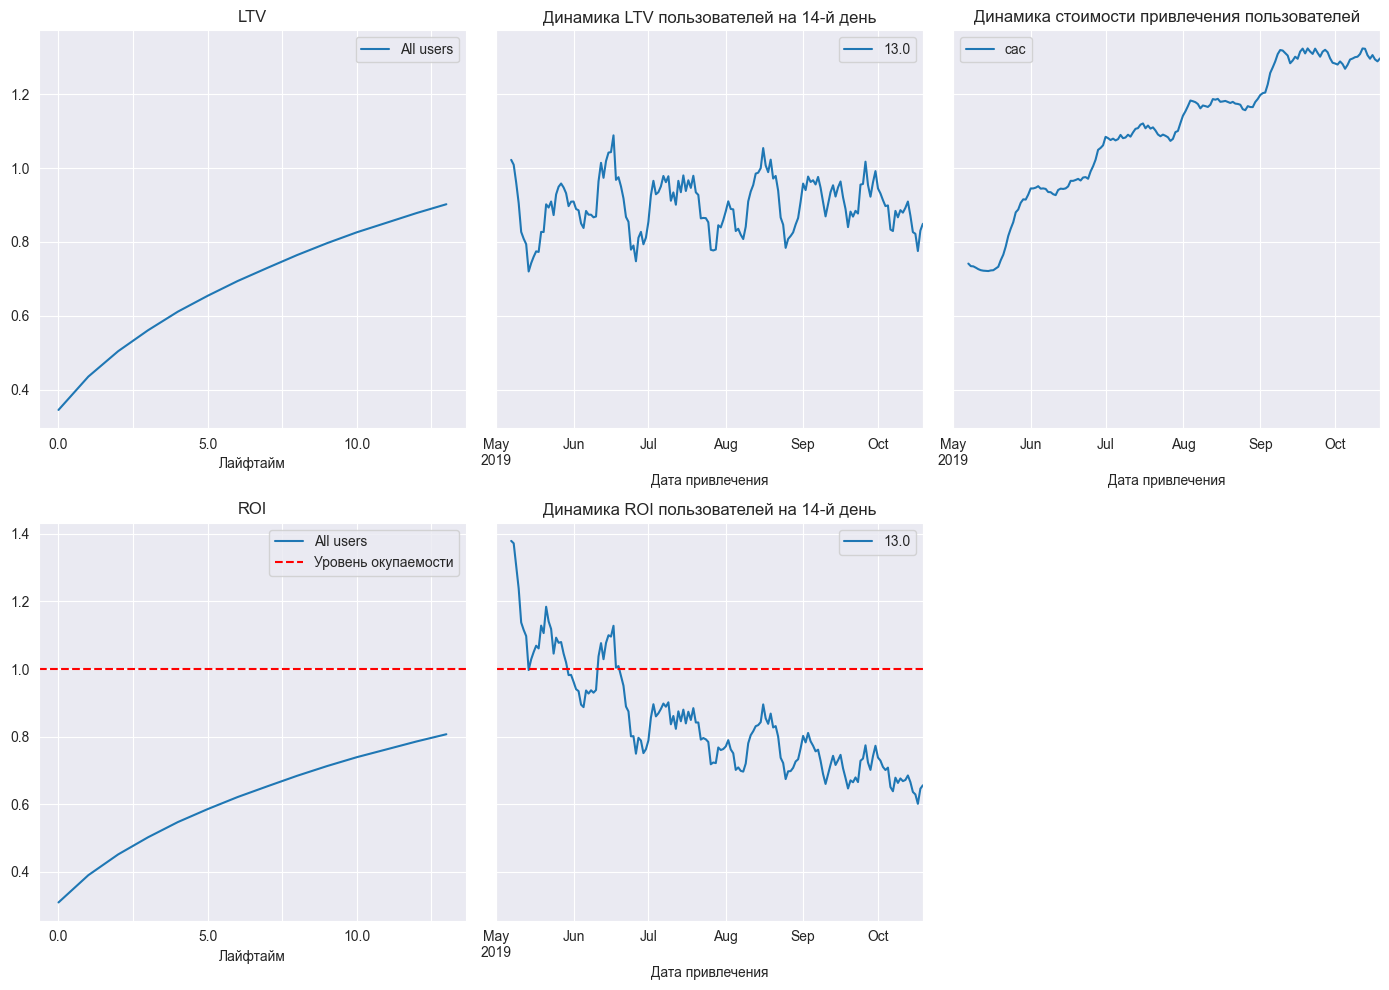

In [46]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date=observation_date, horizon_days=horizon_days
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

На конец горизонта анализа, к 14 дню, ROI приблизился к уровню окупаемости (составил 0.8), но так и не достиг его. То есть за 2 недели наши рекламные расходы не окупаются. 

Если посмотреть на график динамики CAC, то видим, что рекламный бюджет сильно увеличился в июне и продолжал расти до самого конца периода. При этом график динамики ROI показывает, что окупаемость не росла вместе с ростом расходов: на начало периода, в мае - июне, ROI был выше уровня окупаемости, но потом упал ниже этого уровня.

Динамика LTV показывает, что в июне были самые высокие показатели LTV, затем чуть снизились и оставались примерно на одном уровне.

## 4.2. Анализ конверсии и удержания

Проверим конверсию пользователей, динамику её изменения, а также удержание пользователей.

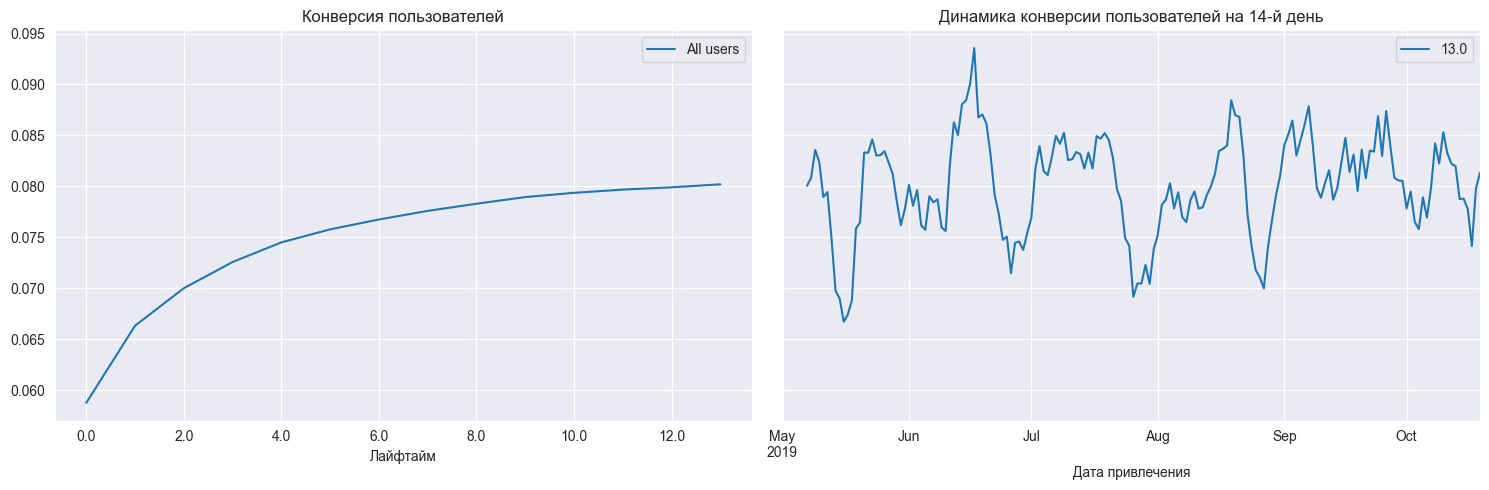

In [47]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Судя по графику, общая конверсия хорошо растет до 4 дня, а потом замедляется и остается прмерно на одном уровне до 14 дня. График динамики показывает, что июньские пользователи конвертировались лучше всех последующих пользователей. 

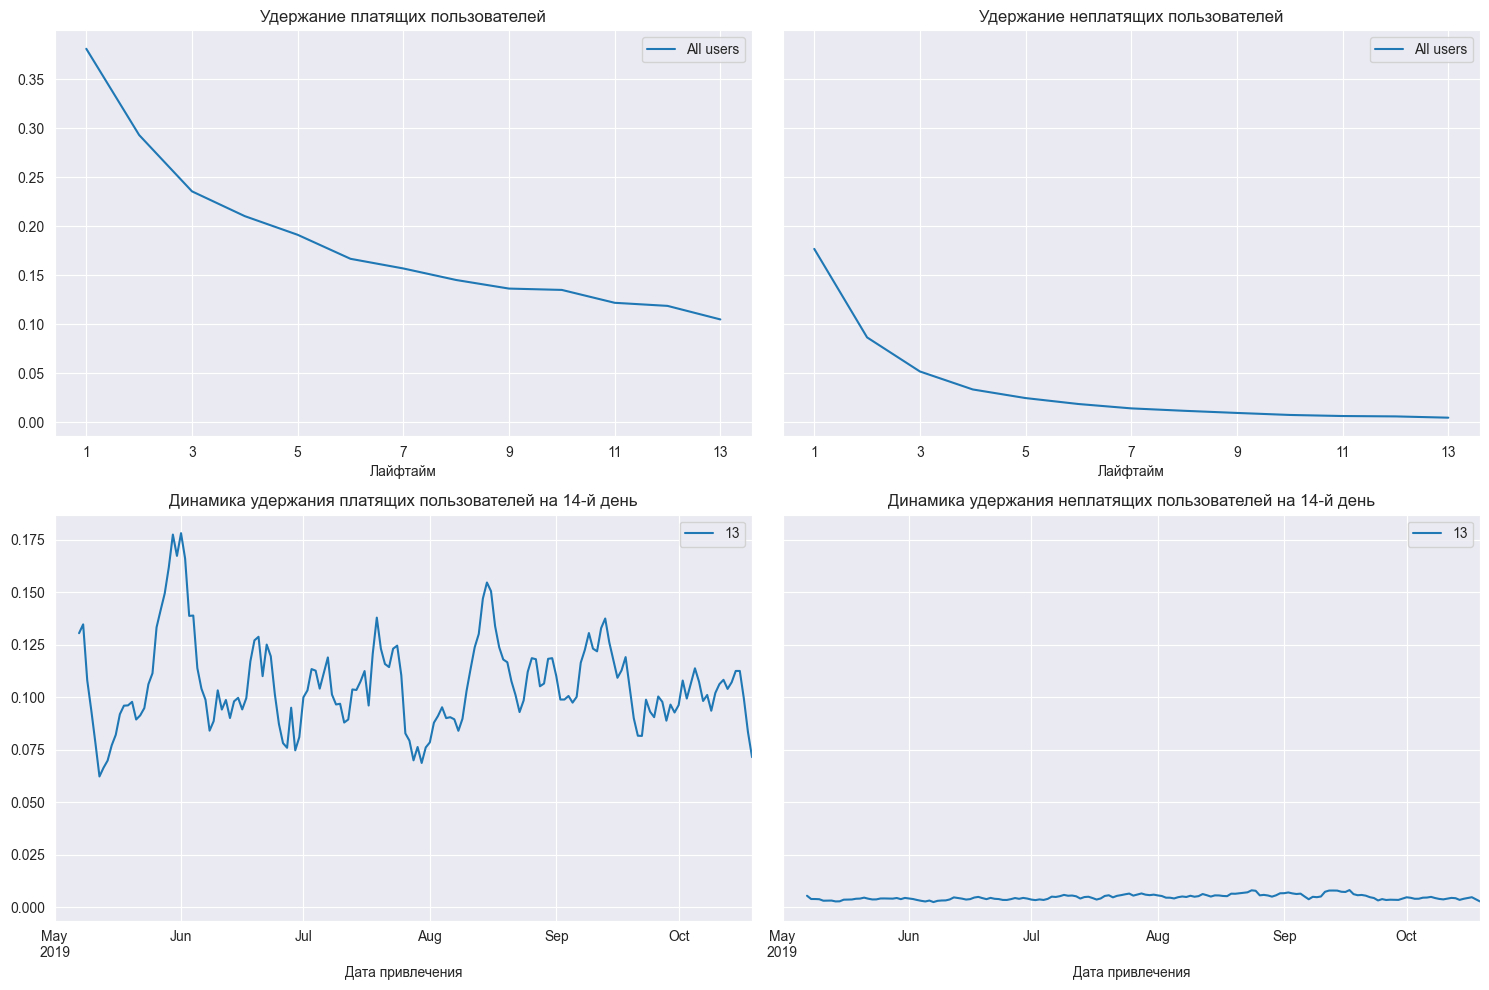

In [48]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days)

Графики удержания показывают сильное падение удержания платящих пользователей в течение первых 4 дней, и падение удержания неплатящих в течение первых 3 дней.

К 14 же дню удержание платящих достигает 0.1, а удержание неплатящих достигает нуля.

График динамики по платящим пользователям показывает уже знакомую нам картину: более высокое удержание июньских пользователей по сравнению с остальными.

График динамики по неплатящим стабилен: удержание здесь в районе нуля.

## 4.3. Окупаемость рекламы в разбивке по устройствам

Проанализируем окупаемость рекламы с разбивкой по устройствам.

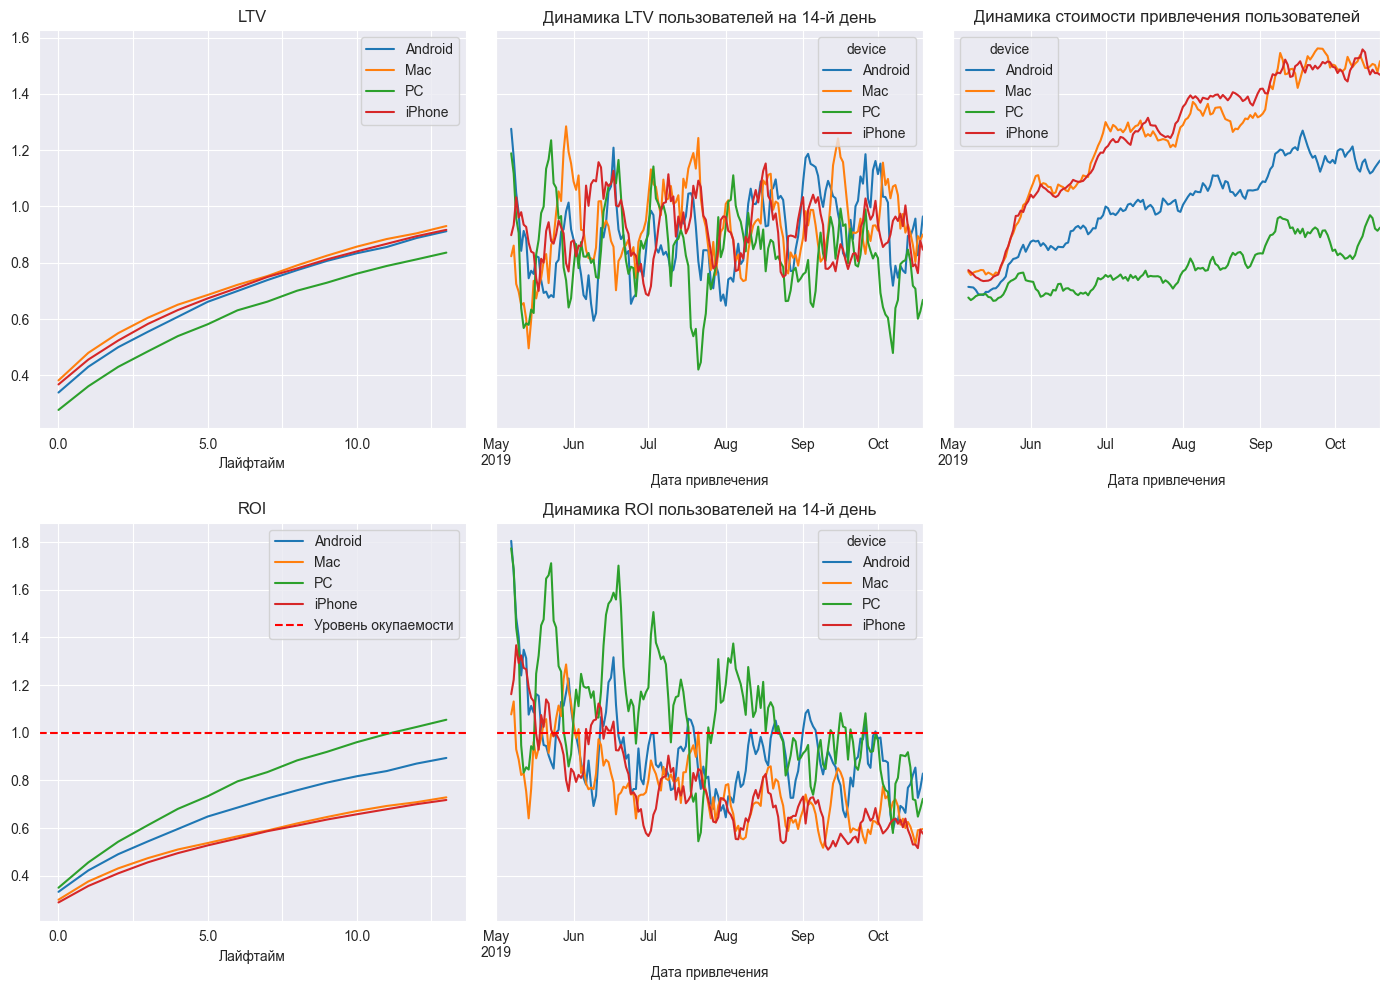

In [49]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days
)

В разбивке по устройствам мы видим, что окупаются у нас только пользователи PC (к 11 дню). Android, iPhone и Mac на уровень окупаемости не выходят. И хотя LTV у пользователей PC ниже, чем у Android, iPhone и Mac, стоимость привлечения на PC тоже неывсока, что и дает хорошую окупаемость рекламы на PC.

График динамики CAC показывает, что реклама на iPhone и Mac гораздо дороже, чем на Android, и PC, т.е. мобильные пользователи обходятся нам дороже, но не приносят так уж много денег.

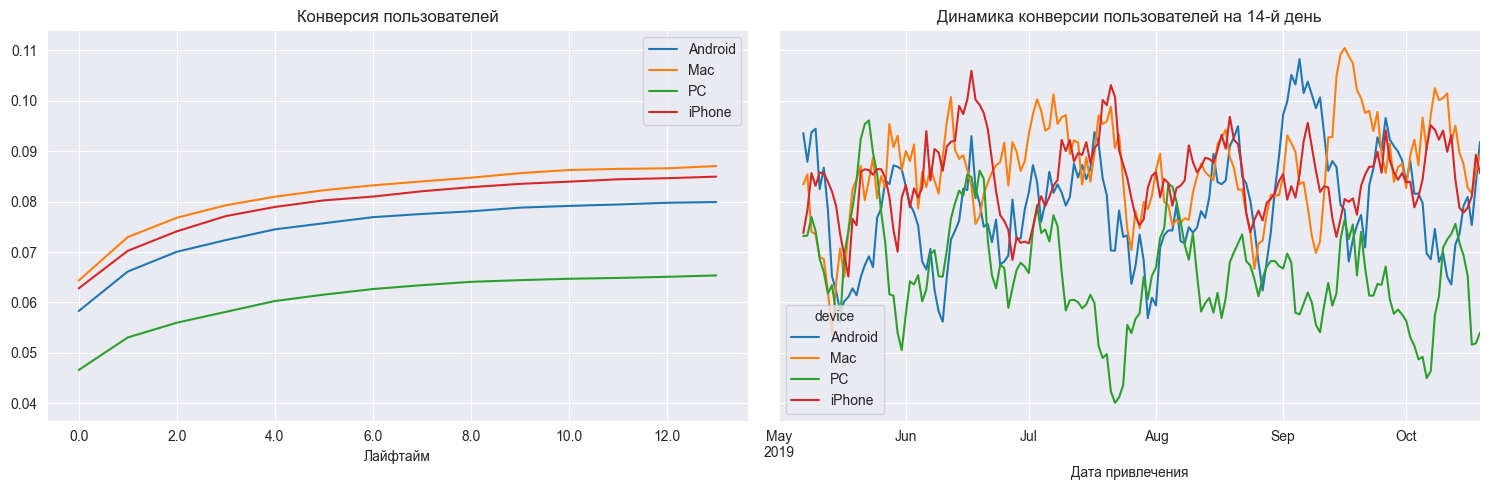

In [50]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия пользователей PC наиболее низкая среди всех устройств, на 14 день она составляет 0.06. Конверсия на других устройствах чуть лучше: у Mac - 0.09, у iPhone и Android - 0.08.

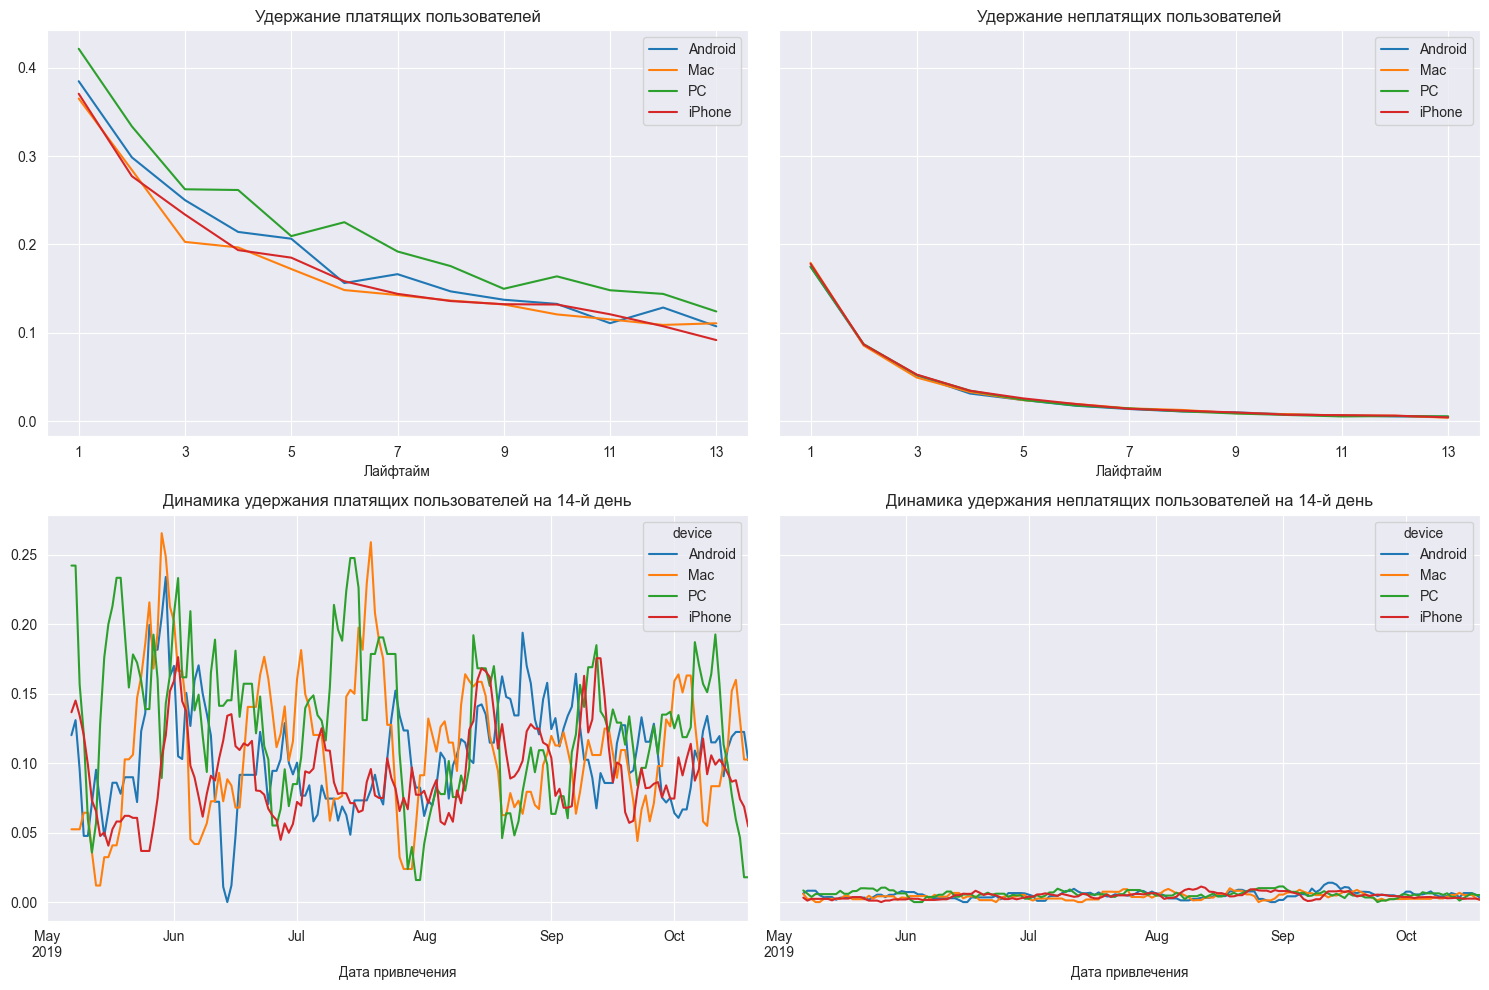

In [51]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

А вот удержание платящих пользователей на PC выше, чем на других устройствах: на 14 день равно 0.12. На Mac - 0.11, Android - 0.1, iPhone - 0.09. Получается, что мобильные пользователи хорошо конвертируются в платящих, но удерживаются хуже, чем пользователи PC.

## 4.4. Окупаемость рекламы в разбивке по странам

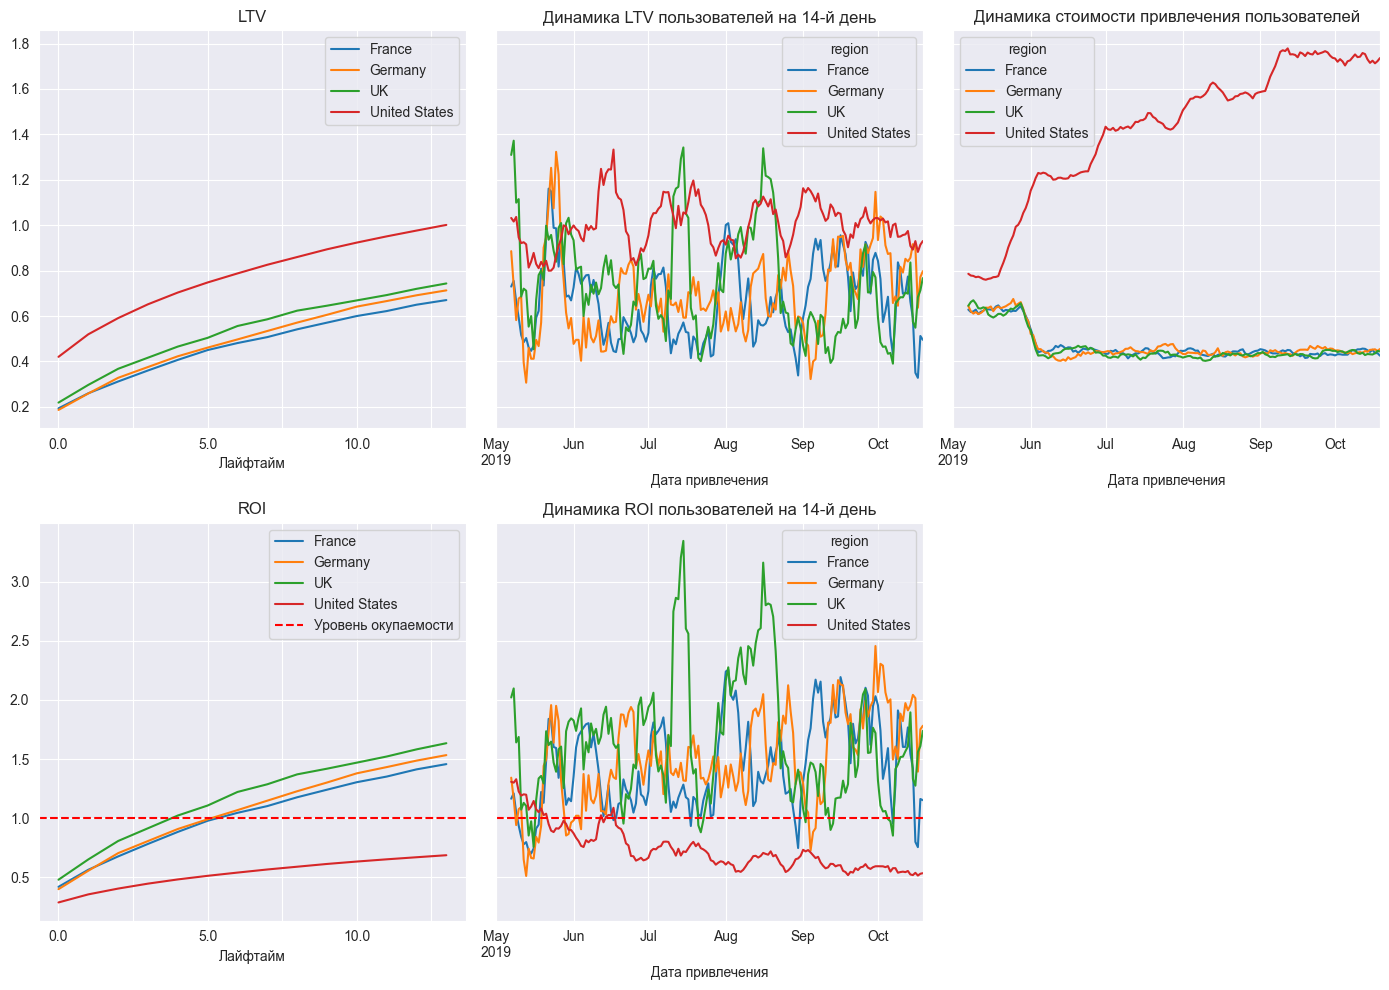

In [52]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days
)

В разбивке по странам, мы видим стабильно высокие значения LTV для пользователей из США. Однако также мы видим огромный отрыв США в стоимости привлечения: стоимость привлечения пользователя из США в несколько раз выше других стран. В итоге несмотря на хороший LTV, пользователи из США не окупаются. В то время как остальные страны выходят на окупаемость в течение 3-5 дней.

Динамика CAC показывает, что в июне произошло резкое увеличение затрат на привлечение пользователей в США, и сокращение затрат на остальные страны. Это не было хорошим решением, т.к. пользователи из США оказались не настолько платежеспособными, чтобы оправдать наши рекламные вложения.

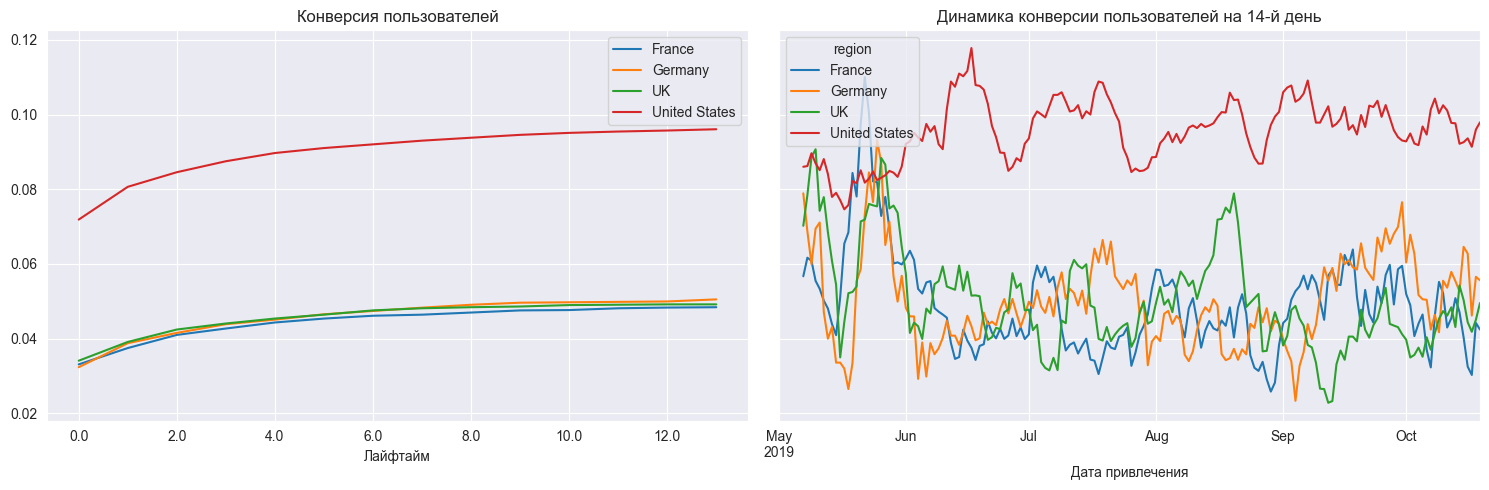

In [53]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия пользователей из США гораздо выше конверсии пользователей из других стран, к 14 дню достигает 0.1. В то время, как конверсия UK, Франции и Германии достигает лишь 0.5.

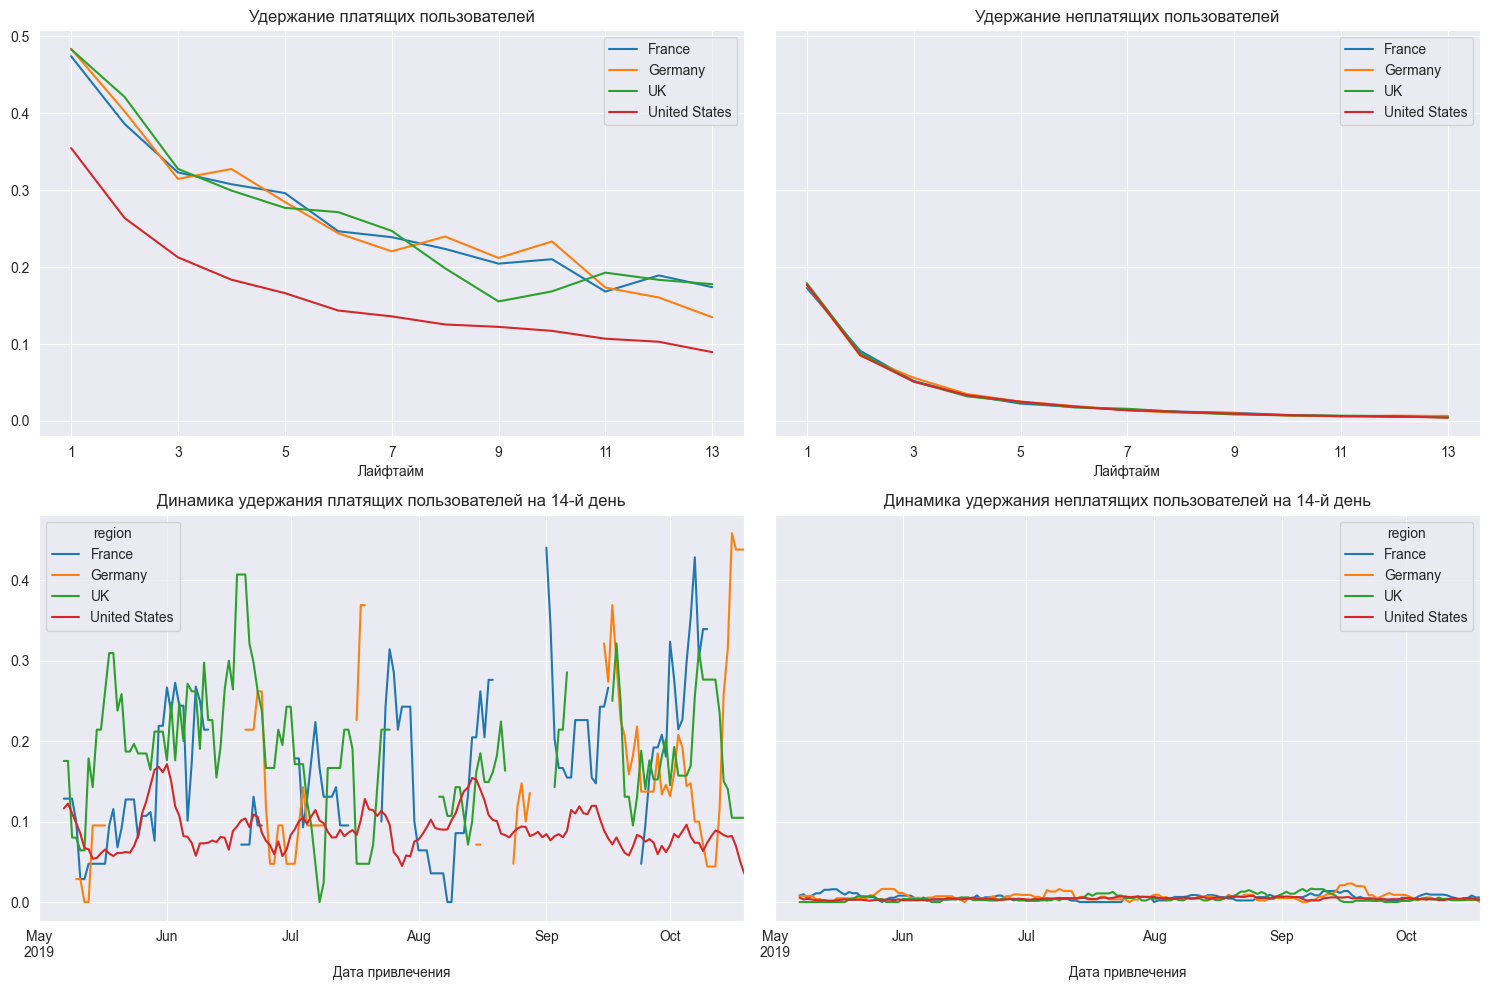

In [54]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание платящих пользователей из США гораздо ниже, чем у других стран: к 14 дню составляет всего 0.9. У Франции и UK удержание 14 дня на уровне 0.17, а у Германии 0.13.

Плохое удержание пользователей из США сводит на нет их хорошую конверсию, и в итоге они не окупаются.

## 4.5. Окупаемость рекламы в разбивке по каналам привлечения

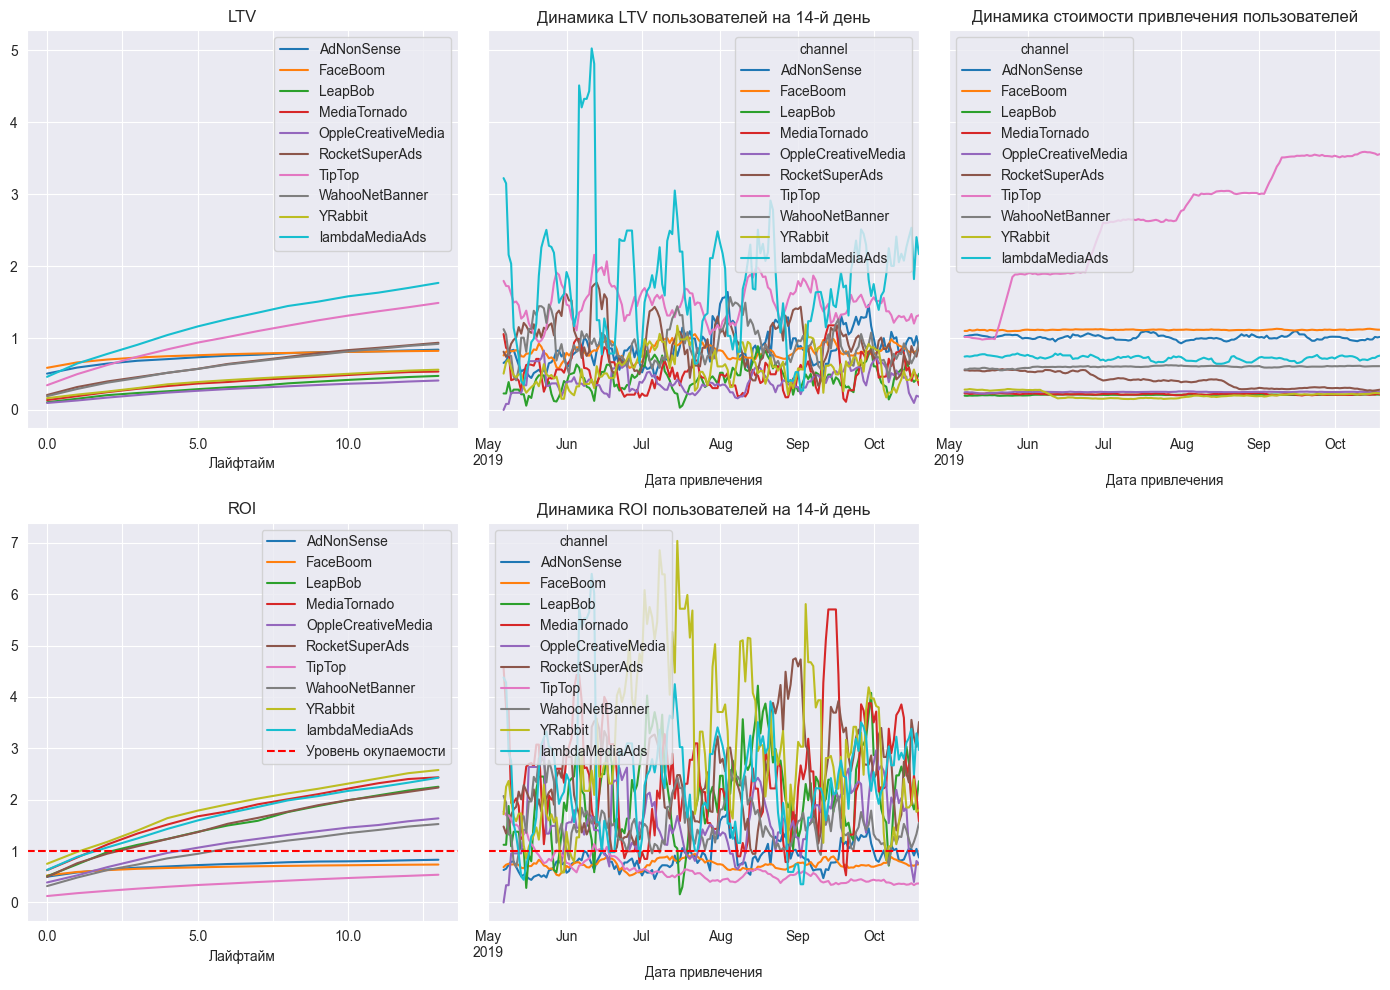

In [55]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days
)

Среди каналов не окупаются TipTop (лидер по затратам, как мы знаем из предыдущего анализа), FaceBoom, AdNonSense. Затраты на каналы выглядят стабильными: некоторые совсем не меняются от месяца к месяцу (как FaceBoom, например), некотрые меняются немного (AdNonSense, lambdaMediaAd). Исключение из этой стабильности - как раз TipTop, затраты на канал резко увеличиваются каждый месяц.

LTV у канала TipTop тоже хороший, но не соответствует всем затратам на него. В этом плане гораздо лучше показывает себя lambdaMediaAd: LTV выше, чем у TipTop, а затраты существенно ниже, отсюда один из самых высоких показателей ROI.

Рекордсменом по ROI стал канал YRabbit: у него самый высокий ROI, превышающий уровень окупаемости в 2 с лишним раза, а затраты стабильно очень низкие. Также мы видим скачок ROI для июльских пользователей с YRabbit: в этом месяце окупаемость этого канала была несколько раз выше всех остальных каналов.

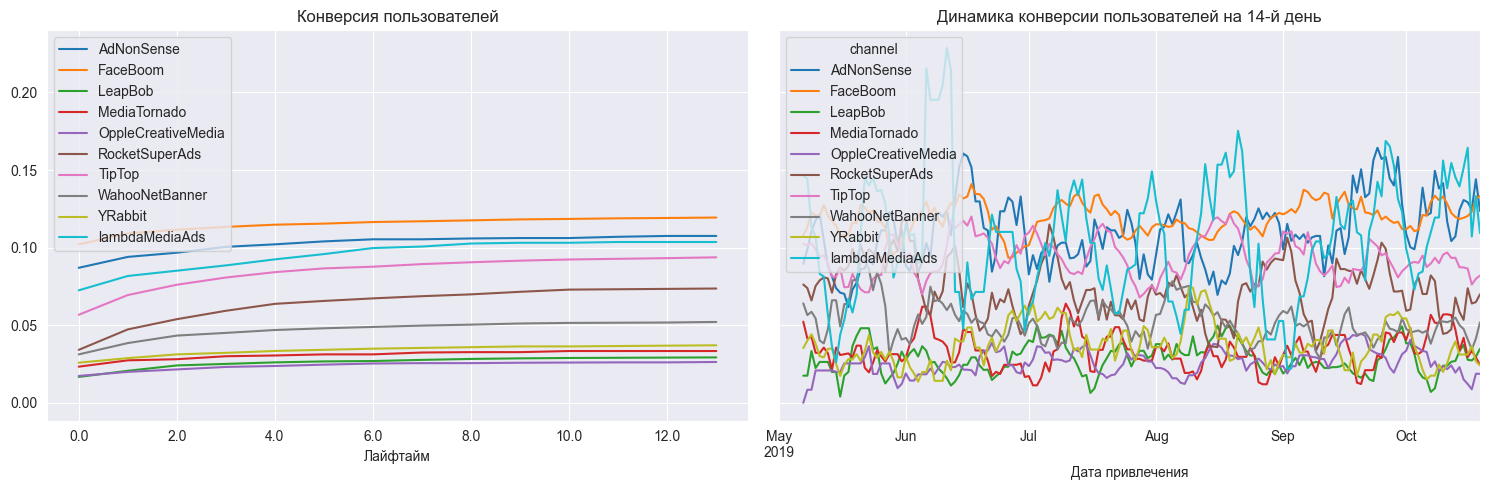

In [56]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

В разбивке по каналам лидерами конверсии оказываются FaceBoom (0.12 к 14 дню), AdNonSense (0.1 к 14 дню), lambdaMediaAds (0.1 к 14 дню). Самая низкая конверсия у OppleCreativeMedia, LeapBob, MediaTornado - все трое в районе 0.03.

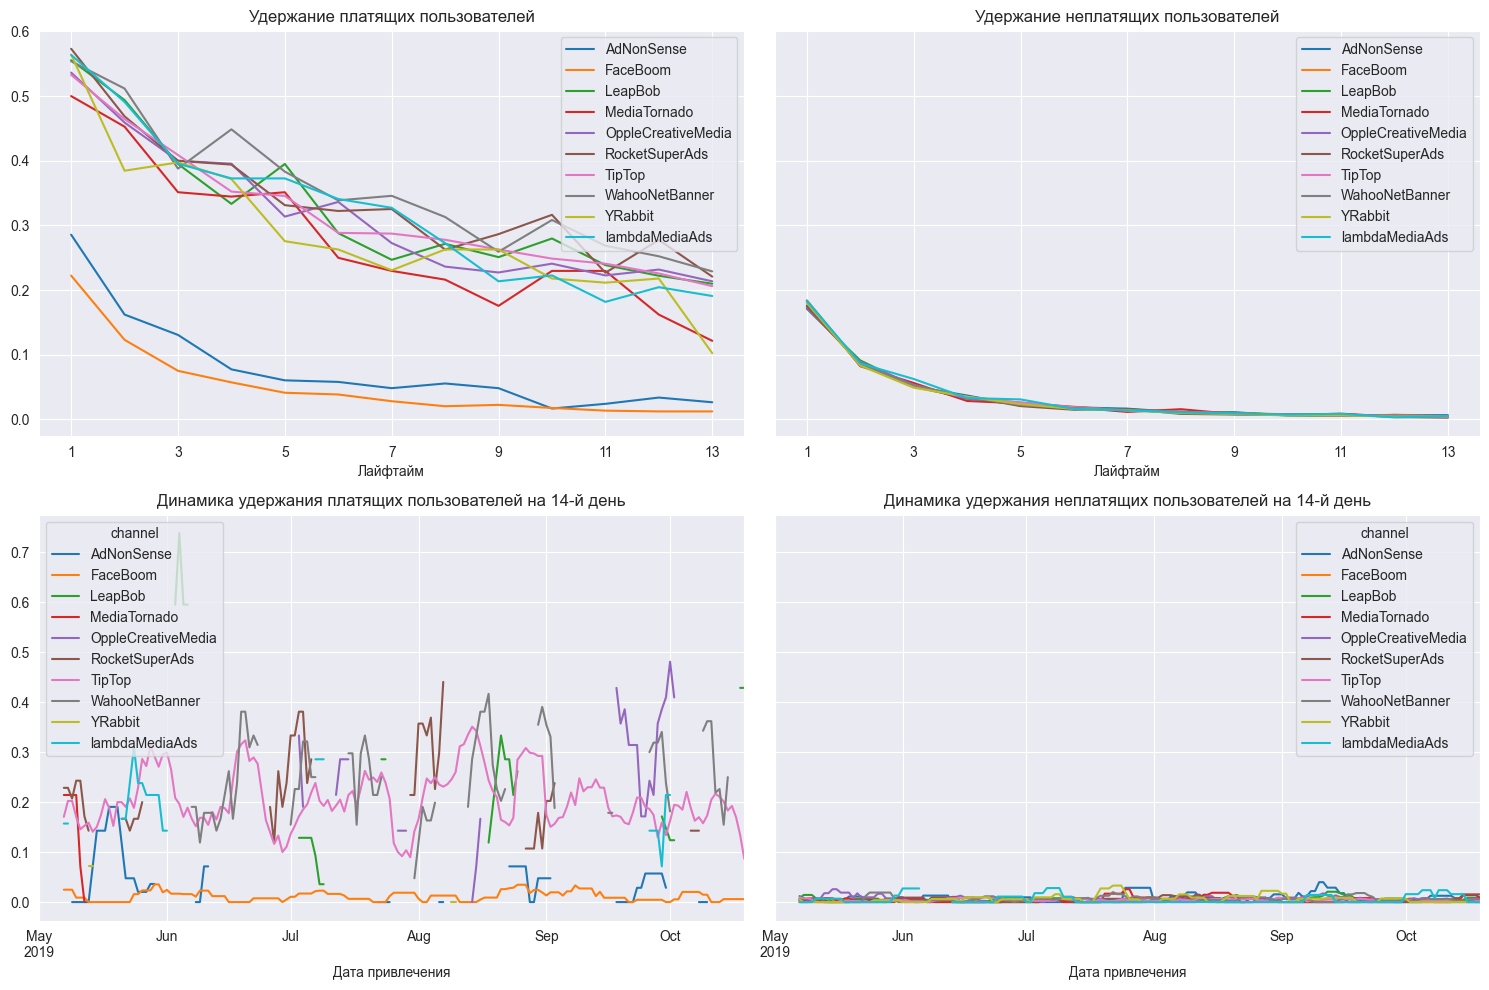

In [57]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание пользователей AdNonSense и FaceBoom самое низкое среди каналов: к 14 дню видим уровень удержания 0.03 у AdNonSense и 0.01 у FaceBoom. То есть эти каналы хорошо конвертируются, но плохо удерживают пользователей.

# 5. Анализ проблемных групп пользователей

Выделим самые проблемные группы пользователей (у них мы выявили самые большие проблемы с окупаемостью):
- пользователи из США
- пользователи, пришедшие из TipTop

Визуализируем их ROI и LTV отдельно от остальных пользователей.

## 5.1. Пользователи из США

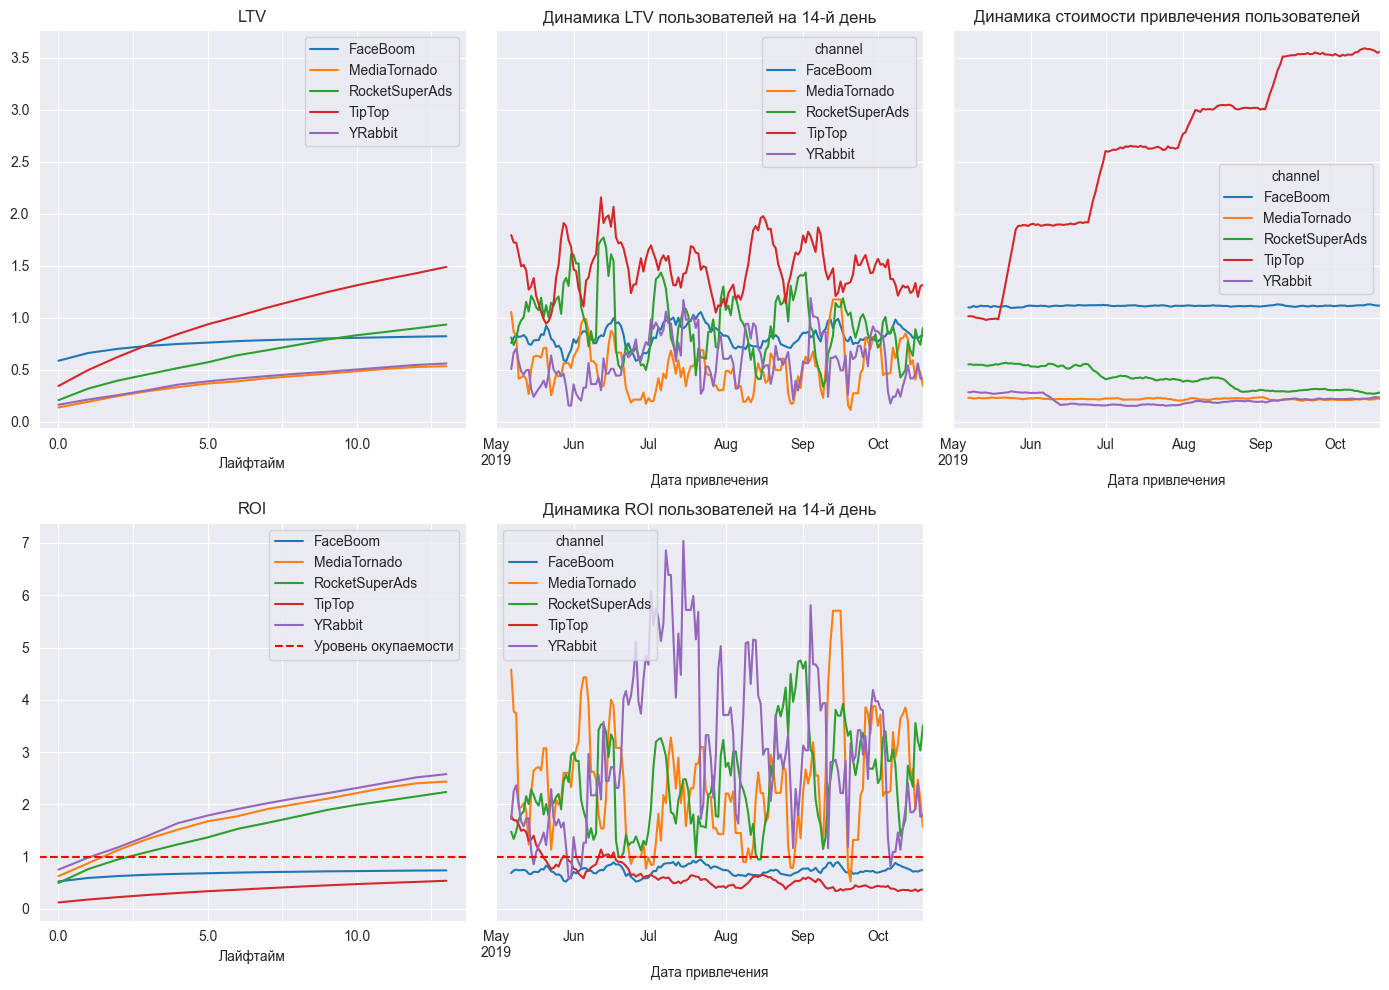

In [58]:
dimensions = ['channel']
us_profiles = profiles.query('region == "United States"')

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    us_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days
)

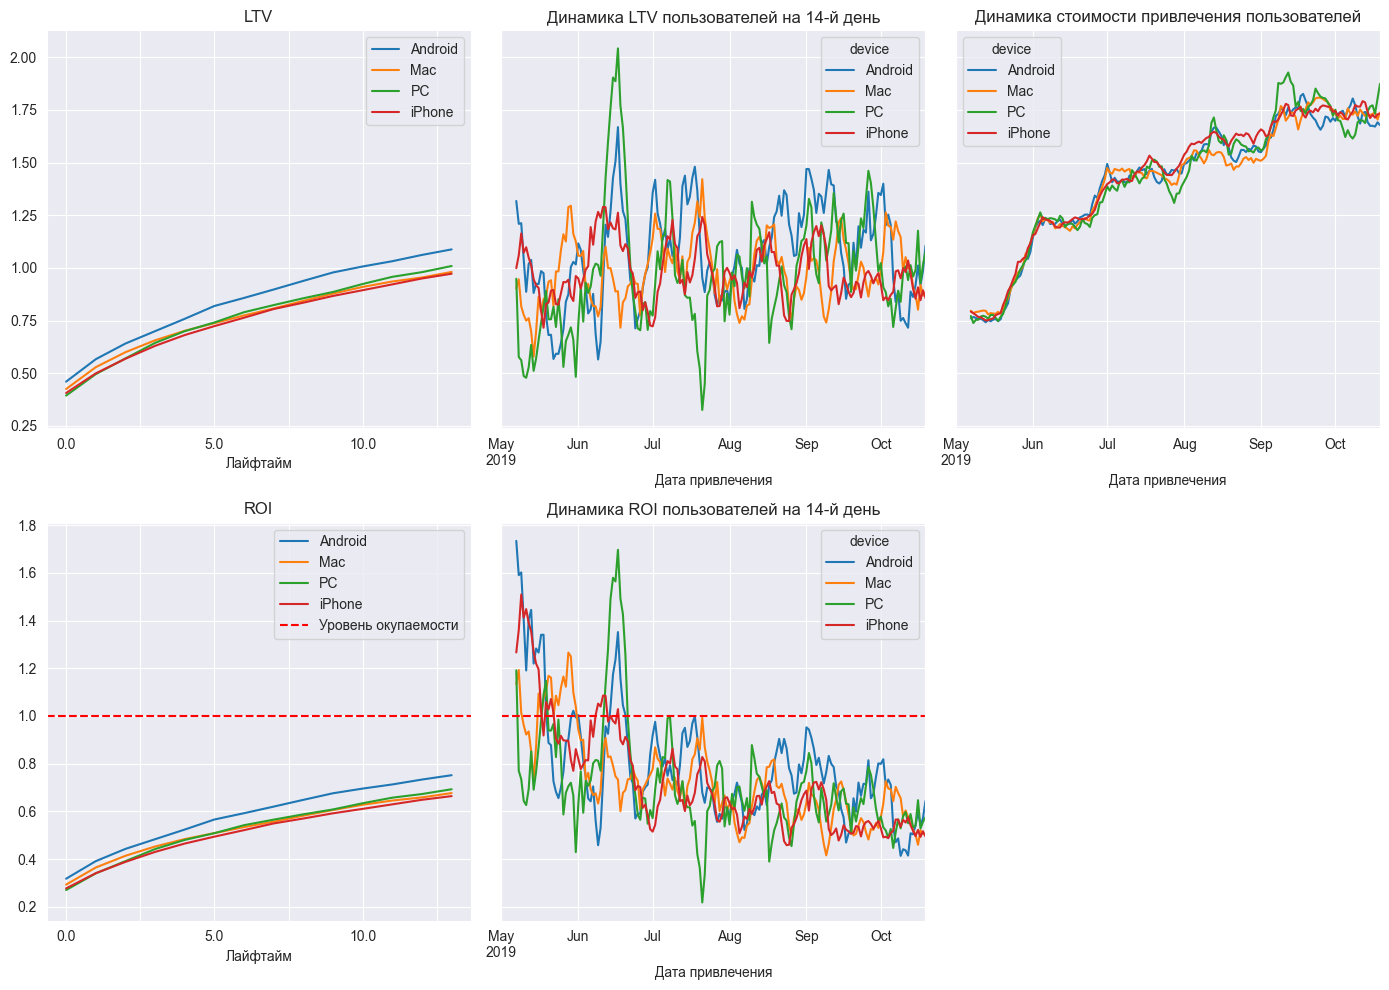

In [59]:
dimensions = ['device']
us_profiles = profiles.query('region == "United States"')

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    us_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days
)

Пользователи из США не окупаются на каналах FaceBoom и TipTop, не окупаются на всех устройствах.

## 5.2. Пользователи TipTop

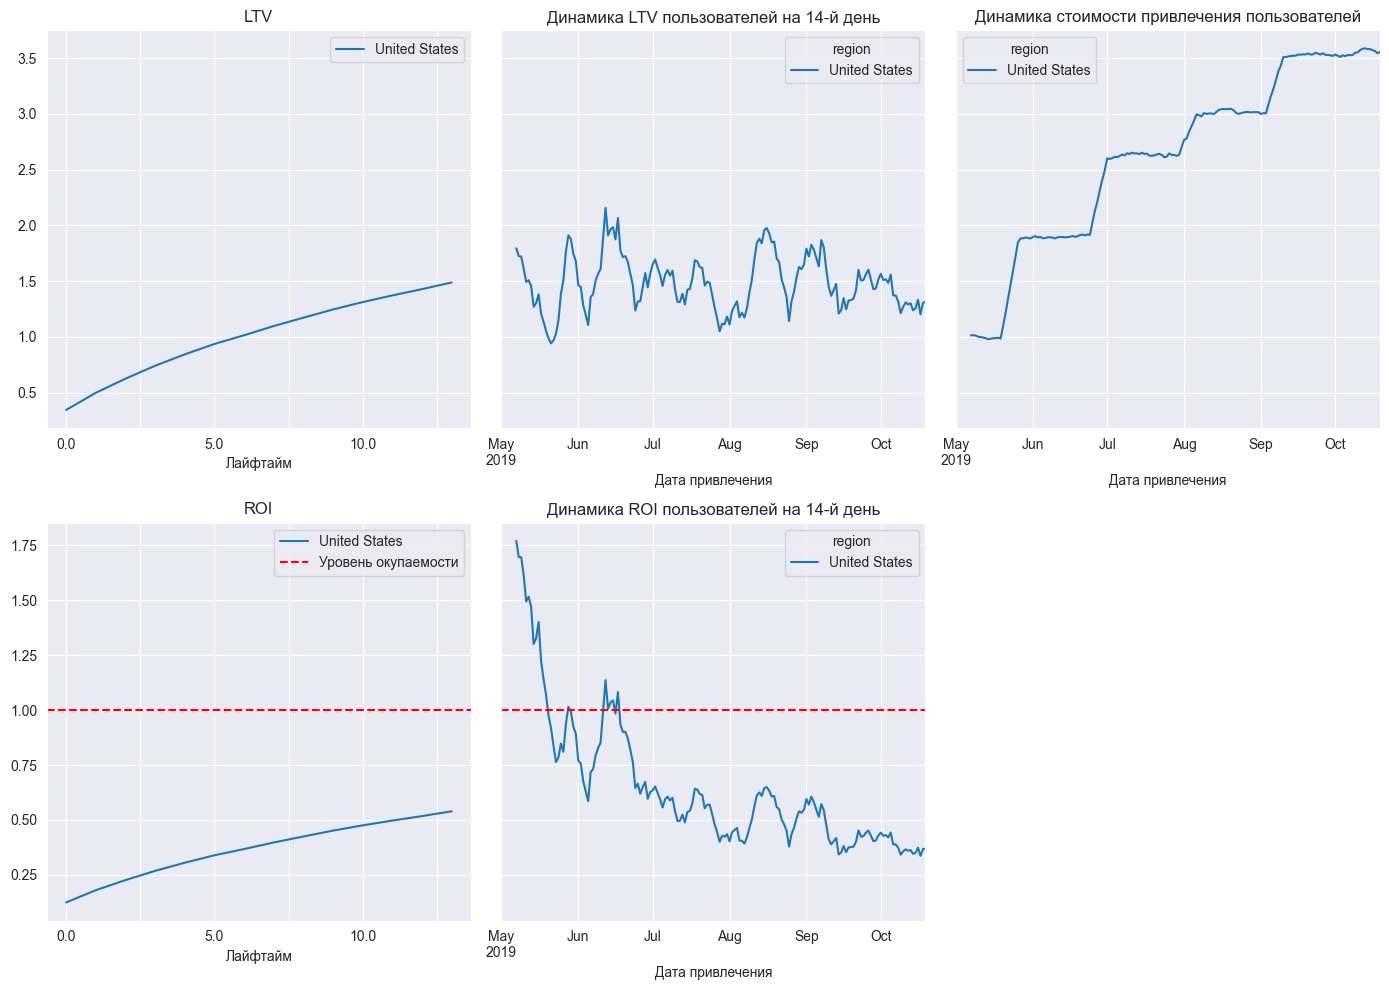

In [60]:
dimensions = ['region']
tt_profiles = profiles.query('channel == "TipTop"')

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    tt_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days
)

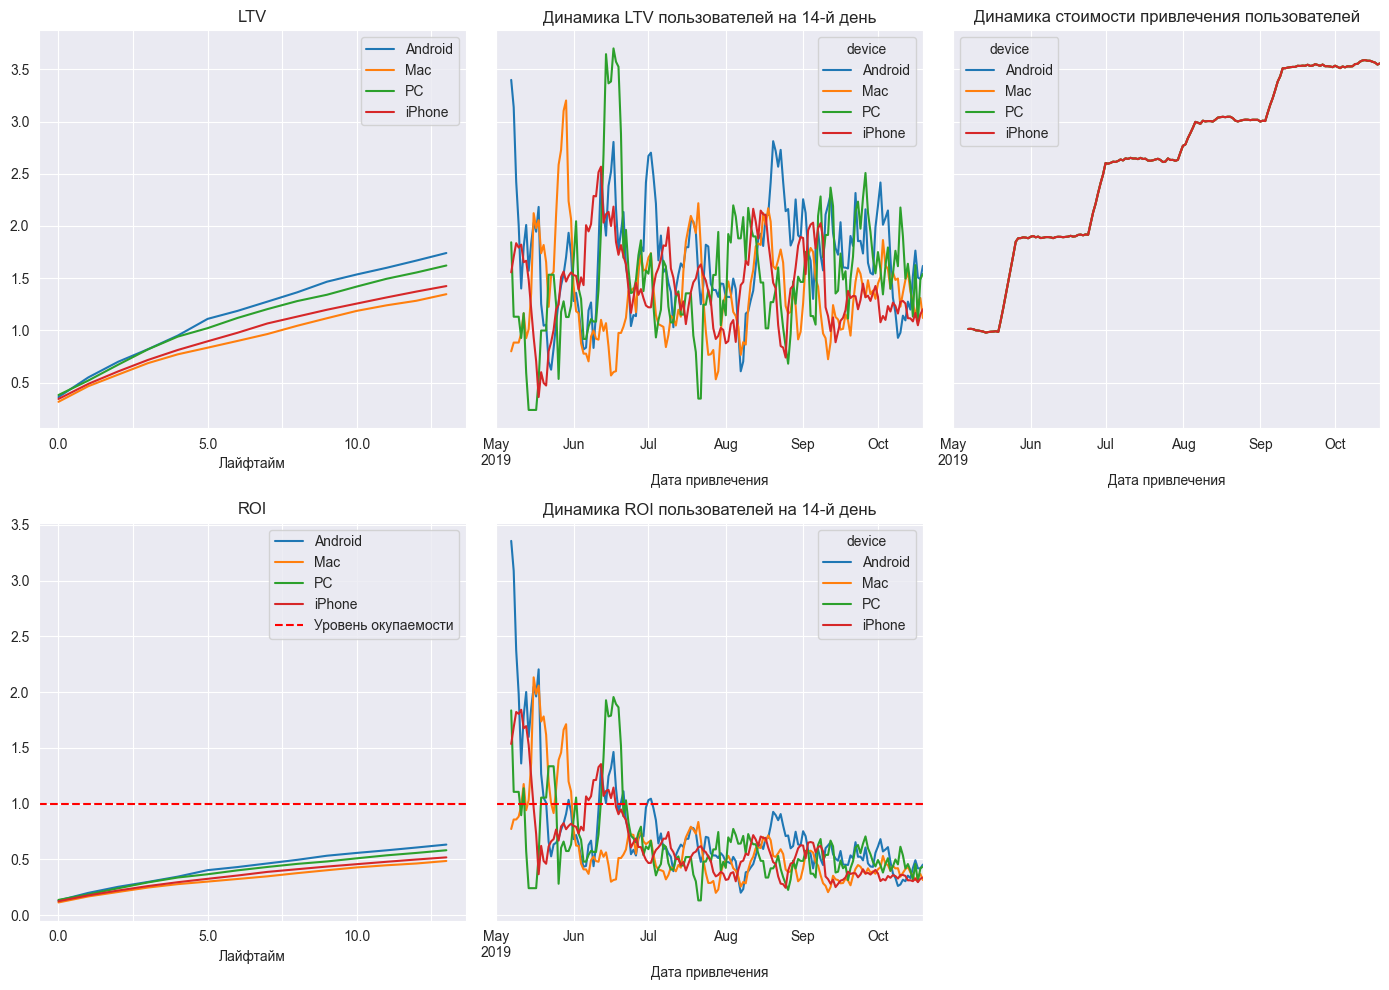

In [61]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    tt_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days
)

Пользователи TipTop встречаются только в одном регионе - США, и там они не окупаются. Не окупаются на всех типах девайсов.

# 6. Выводы

Проведя анализ привлечения пользователей за период с 1 мая по 27 октября 2019, мы обнаружили, что рекламные расходы в целом не окупаются. Это мы видим из значений ROI - его значение не достигает единицы. Причем если для первых когорт привлеченных пользователей (май, июнь, июль) ROI оставался выше уровня окупаемости, то затем он упал ниже этого уровня.

Главным фактором, повлиявшим на падение ROI, можно считать рост рекламных расходов, который начался в июне. Стабильно много рекламных денег тратилось на привлечение пользователей платформ iPhone и Mac. Но при этом, эти пользователи не росли в LTV, и в итоге расходы на них не окупались. Также мы видим, что существенные расходы на привлечение американских пользователей тоже не дали положительных результатов: даже высокие значения LTV этих пользователей не позволяют им выйти на уровень окупаемости. Самым затратным и при этом неэффективным каналом привлечения был TipTop - регулярно растущие на него расходы не привели к такому же быстрорастущему LTV.

## 6.1. Проблемные категории пользователей

Суммируя проведенный анализ, мы имеем несколько *неокупающихся* групп пользователей:

1. Пользователи *iPhone*, *Android* и *Mac*. Для всех этих устройств характерно такое сочетание ключевых показателей: хорошая конверсия + плохое удержание. В случае с *iPhone* и *Mac* к этому добавляется высокая стоимость привлечения (и вероятно, именно дорогивизна рекламы на iOS вносит самый внушительный негативный вклад). Можно пробовать работать с удержанием таких пользователей, либо сократить бюджет на рекламу на этих устройствах.

2. Пользователи из *США*. Эта группа пользователей характеризуется очень хорошей конверсией, очень плохим удержанием и очень высокими и постоянно растущими расходами на привлечение. Расходы на привлечение в *США* - это во многом расходы на *TipTop* - канал, который не окупается. Сокращение именно это канала может улучшить окупаемость *США*. Вместо TipTop расходы можно направить на окупающиеся в *США* каналы: *YRabbit*, *MediaTornado*, *RocketSuperAds*.

3. Пользователи, пришедшие с *TipTop*, *FaceBoom*, *AdNonSense*. В плохой окупаемости *FaceBoom* и *AdNonSense* главную роль играет очень плохое удержание (конверсия у каналов хорошая, и затраты не слишком велики). Что касается *TipTop* - здесь большие и постоянно растущие расходы при не самой высокой конверсии, этот канал явно неудачный.

## 6.2. Перспективные категории пользователей

*Окупаются* следующие группы пользователей:
1. Пользователи *PC*. Окупаются они по всем каналам, кроме *FaceBoom* и *TipTop*, о проблемах этих каналов мы говорили ранее. А также по всем странам, кроме *США*.
2. Пользователи из *Европы*. Для них не окупается лишь канал *AdNonSense* (а затраты на него самые высокие, можно их сократить в пользу других каналов). Зато очень хорошие показатели у *lambdaMediaAds*, следует наращивать его использование. Европейские пользователи окупаются на всех устройствах.
3. Пользователи, пришедшие со всех каналов, кроме *TipTop*, *FaceBoom*, *AdNonSense*. Эти пользователи окупаются во всех странах и на всех платформах.